In [511]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels as ss
import statsmodels.api as sm

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [512]:
df = pd.read_csv('D202.csv')

In [513]:
df.head()

,TYPE,DATE,START TIME,END TIME,USAGE,UNITS,COST,NOTES
0,Electric usage,10/22/2016,0:00,0:14,0.01,kWh,$0.00,NaN
1,Electric usage,10/22/2016,0:15,0:29,0.01,kWh,$0.00,NaN
2,Electric usage,10/22/2016,0:30,0:44,0.01,kWh,$0.00,NaN
3,Electric usage,10/22/2016,0:45,0:59,0.01,kWh,$0.00,NaN
4,Electric usage,10/22/2016,1:00,1:14,0.01,kWh,$0.00,NaN


In [514]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        70368 non-null  object 
 1   DATE        70368 non-null  object 
 2   START TIME  70368 non-null  object 
 3   END TIME    70368 non-null  object 
 4   USAGE       70368 non-null  float64
 5   UNITS       70368 non-null  object 
 6   COST        70368 non-null  object 
 7   NOTES       0 non-null      float64
dtypes: float64(2), object(6)
memory usage: 4.3+ MB


In [515]:
df.drop(['TYPE', 'START TIME', 'END TIME', 'UNITS', 'NOTES'], axis=1, inplace=True)

In [516]:
df['DATE'] = pd.to_datetime(df['DATE'])

In [517]:
df['COST'] = df['COST'].str.replace('$', '').astype(float)

In [518]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70368 entries, 0 to 70367
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    70368 non-null  datetime64[ns]
 1   USAGE   70368 non-null  float64       
 2   COST    70368 non-null  float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 1.6 MB


In [519]:
df.describe()

,USAGE,COST
count,70368.000000,70368.000000
mean,0.121941,0.024684
std,0.210507,0.042646
min,0.000000,0.000000
25%,0.030000,0.010000
50%,0.050000,0.010000
75%,0.120000,0.020000
max,2.360000,0.650000


In [520]:
df.head()

,DATE,USAGE,COST
0,2016-10-22,0.01,0.0
1,2016-10-22,0.01,0.0
2,2016-10-22,0.01,0.0
3,2016-10-22,0.01,0.0
4,2016-10-22,0.01,0.0


In [521]:
min_date = np.min(df['DATE'])
max_date = np.max(df['DATE'])

print('Earliest recorded:', min_date)
print('Latest recorded:', max_date)

Earliest recorded: 2016-10-22 00:00:00
Latest recorded: 2018-10-24 00:00:00


In [522]:
dates = df['DATE'].unique()
usage = []
cost = []

for day in dates:
    usage.append(np.sum(df[df['DATE'] == day]['USAGE']))
    cost.append(np.sum(df[df['DATE'] == day]['COST']))
    
data = {'Date': dates, 'Cost': cost}

ts_data = pd.DataFrame(data, columns=['Date', 'Cost'])

In [619]:
ts_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 733 entries, 2016-10-22 to 2018-10-24
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Cost    733 non-null    float64
dtypes: float64(1)
memory usage: 11.5 KB


In [523]:
ts_data.head()

,Date,Cost
0,2016-10-22,0.60
1,2016-10-23,4.36
2,2016-10-24,1.20
3,2016-10-25,1.60
4,2016-10-26,0.84


In [524]:
ts_data.set_index('Date', inplace=True)
ts_data.head()

,Cost
Date,
2016-10-22,0.60
2016-10-23,4.36
2016-10-24,1.20
2016-10-25,1.60
2016-10-26,0.84


In [525]:
print('Days electricity recorded:', len(ts_data.index))

Days electricity recorded: 733


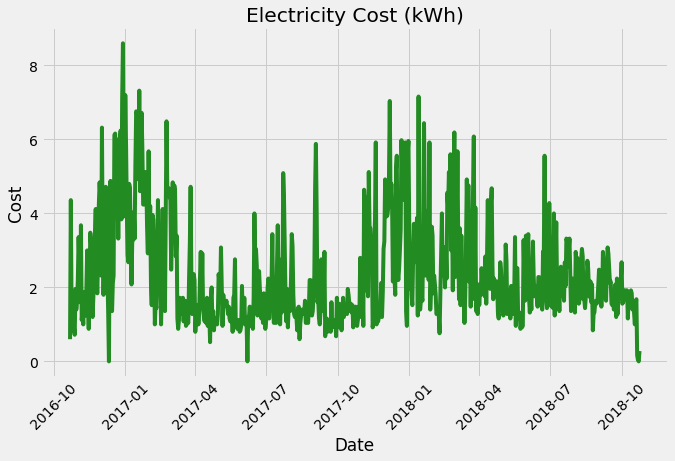

In [526]:
fig = plt.figure(figsize=(10,6))

plt.plot(ts_data.index, ts_data['Cost'], color='forestgreen', label='Cost')
plt.xlabel('Date')
plt.ylabel('Cost')
plt.title('Electricity Cost (kWh)')
plt.xticks(rotation=45)
plt.show()

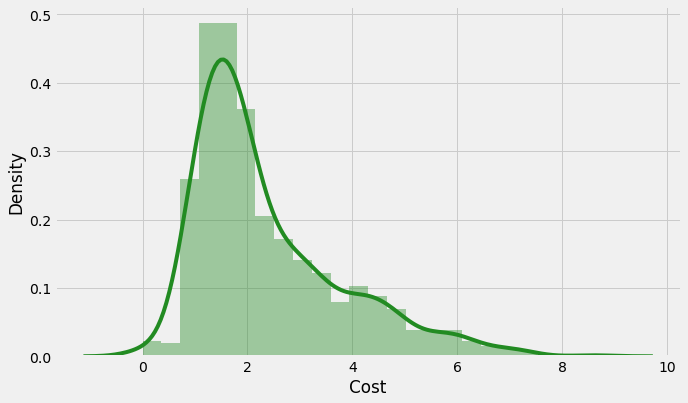

In [527]:
fig = plt.figure(figsize=(10,6))

sns.distplot(ts_data['Cost'], color='forestgreen')
plt.show()

In [528]:
ts_data_weekly = ts_data['Cost'].resample('W').sum()
ts_data_monthly = ts_data['Cost'].resample('M').sum()
ts_data_quarterly = ts_data['Cost'].resample('Q').sum()
ts_data_annual = ts_data['Cost'].resample('Y').sum()

In [529]:
ss_decomposition = seasonal_decompose(x=ts_data, model='additive', period=7)

In [530]:
estimated_trend = ss_decomposition.trend
estimated_seasonal = ss_decomposition.seasonal
estimated_residual = ss_decomposition.resid

In [531]:
estimated_trend.head(13)[3:]

Date
2016-10-25    1.462857
2016-10-26    1.657143
2016-10-27    1.234286
2016-10-28    1.297143
2016-10-29    1.382857
2016-10-30    1.742857
2016-10-31    1.982857
2016-11-01    2.108571
2016-11-02    2.354286
2016-11-03    2.314286
Name: trend, dtype: float64

In [532]:
estimated_seasonal.head(13)[3:]

Date
2016-10-25   -0.194846
2016-10-26   -0.192772
2016-10-27   -0.134214
2016-10-28   -0.054736
2016-10-29    0.256019
2016-10-30    0.343808
2016-10-31   -0.023258
2016-11-01   -0.194846
2016-11-02   -0.192772
2016-11-03   -0.134214
Name: seasonal, dtype: float64

In [533]:
estimated_residual.head(13)[3:]

Date
2016-10-25    0.331989
2016-10-26   -0.624371
2016-10-27   -0.180071
2016-10-28   -0.522407
2016-10-29    0.321124
2016-10-30   -0.686665
2016-10-31   -0.319599
2016-11-01    0.286275
2016-11-02    1.198486
2016-11-03    0.419929
Name: resid, dtype: float64

In [534]:
estimated_trend.index

DatetimeIndex(['2016-10-22', '2016-10-23', '2016-10-24', '2016-10-25',
               '2016-10-26', '2016-10-27', '2016-10-28', '2016-10-29',
               '2016-10-30', '2016-10-31',
               ...
               '2018-10-15', '2018-10-16', '2018-10-17', '2018-10-18',
               '2018-10-19', '2018-10-20', '2018-10-21', '2018-10-22',
               '2018-10-23', '2018-10-24'],
              dtype='datetime64[ns]', name='Date', length=733, freq=None)

In [535]:
data = {'Trend': estimated_trend, 'Seasonal': estimated_seasonal, 'Residual': estimated_residual}
composition = pd.DataFrame(data, columns=['Trend', 'Seasonal', 'Residual'], index=estimated_trend.index)
composition.head(10)

,Trend,Seasonal,Residual
Date,,,
2016-10-22,NaN,0.256019,NaN
2016-10-23,NaN,0.343808,NaN
2016-10-24,NaN,-0.023258,NaN
2016-10-25,1.462857,-0.194846,0.331989
2016-10-26,1.657143,-0.192772,-0.624371
2016-10-27,1.234286,-0.134214,-0.180071
2016-10-28,1.297143,-0.054736,-0.522407
2016-10-29,1.382857,0.256019,0.321124
2016-10-30,1.742857,0.343808,-0.686665


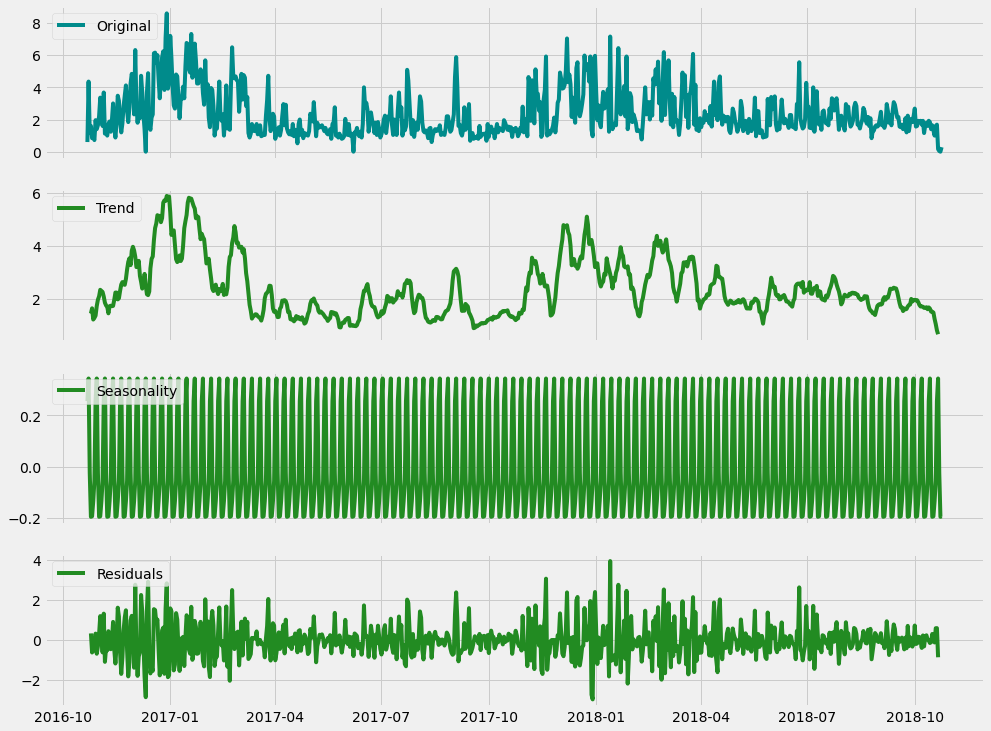

In [536]:
fig, axes = plt.subplots(4, 1, figsize=(15,12), sharex=True, sharey=False)

axes[0].plot(ts_data, label='Original', color='darkcyan')
axes[0].legend(loc='upper left');

axes[1].plot(estimated_trend, label='Trend', color='forestgreen')
axes[1].legend(loc='upper left');

axes[2].plot(estimated_seasonal, label='Seasonality', color='forestgreen')
axes[2].legend(loc='upper left');

axes[3].plot(estimated_residual, label='Residuals', color='forestgreen')
axes[3].legend(loc='upper left');

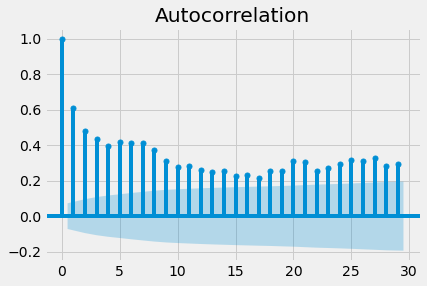

In [537]:
plot_acf(ts_data);

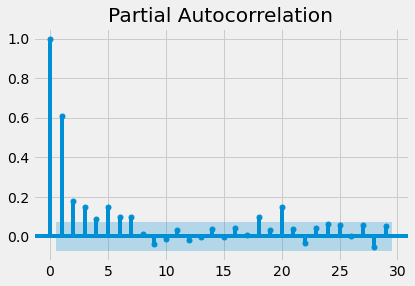

In [538]:
plot_pacf(ts_data);

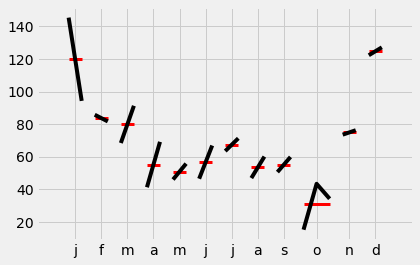

In [539]:
month_plot(ts_data_monthly);

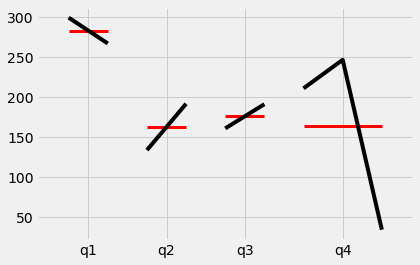

In [540]:
quarter_plot(ts_data_quarterly);

In [541]:
adf, pvalue, usedlag, nobs, critical_values, icbest = adfuller(ts_data)

In [542]:
print('Summary statistics')
print('adf:', adf)
print('p value:', pvalue)
print('used lag:', usedlag)
print('number of observations:', nobs)
print('critical values:', critical_values)
print('icbest:', icbest)

Summary statistics
adf: -2.6315469612542324
p value: 0.08665084537270223
used lag: 19
number of observations: 713
critical values: {'1%': -3.43955476721974, '5%': -2.865602155751202, '10%': -2.5689331692727135}
icbest: 2108.3934371297855


In [543]:
train = ts_data[:-30]
test = ts_data[-30:]

In [544]:
smoothed_data_1 = SimpleExpSmoothing(train).fit(optimized=True)
smoothed_data_preds_1 = smoothed_data_1.forecast(len(test))
smoothed_data_preds

2018-10-20    1.760918
2018-10-21    1.898706
2018-10-22    1.496591
2018-10-23    1.328514
2018-10-24    1.332071
Freq: D, dtype: float64

In [545]:
smoothed_data_2 = Holt(train).fit(optimized=True)
smoothed_data_preds_2 = smoothed_data_2.forecast(len(test))
smoothed_data_preds_2

2018-09-25    1.590956
2018-09-26    1.590756
2018-09-27    1.590556
2018-09-28    1.590356
2018-09-29    1.590156
2018-09-30    1.589956
2018-10-01    1.589756
2018-10-02    1.589556
2018-10-03    1.589356
2018-10-04    1.589156
2018-10-05    1.588956
2018-10-06    1.588756
2018-10-07    1.588556
2018-10-08    1.588356
2018-10-09    1.588156
2018-10-10    1.587956
2018-10-11    1.587756
2018-10-12    1.587556
2018-10-13    1.587356
2018-10-14    1.587156
2018-10-15    1.586956
2018-10-16    1.586756
2018-10-17    1.586556
2018-10-18    1.586356
2018-10-19    1.586156
2018-10-20    1.585956
2018-10-21    1.585756
2018-10-22    1.585556
2018-10-23    1.585356
2018-10-24    1.585156
Freq: D, dtype: float64

In [546]:
smoothed_data_3 = ExponentialSmoothing(train, trend='additive', seasonal='additive', seasonal_periods=7).fit(optimized=True)
smoothed_data_preds_3 = smoothed_data_3.forecast(len(test))
smoothed_data_preds_3

2018-09-25    1.303200
2018-09-26    1.314500
2018-09-27    1.362600
2018-09-28    1.437600
2018-09-29    1.743570
2018-09-30    1.885055
2018-10-01    1.468223
2018-10-02    1.302116
2018-10-03    1.313416
2018-10-04    1.361516
2018-10-05    1.436516
2018-10-06    1.742486
2018-10-07    1.883971
2018-10-08    1.467139
2018-10-09    1.301032
2018-10-10    1.312332
2018-10-11    1.360432
2018-10-12    1.435432
2018-10-13    1.741402
2018-10-14    1.882887
2018-10-15    1.466055
2018-10-16    1.299948
2018-10-17    1.311248
2018-10-18    1.359348
2018-10-19    1.434348
2018-10-20    1.740318
2018-10-21    1.881803
2018-10-22    1.464971
2018-10-23    1.298864
2018-10-24    1.310164
Freq: D, dtype: float64

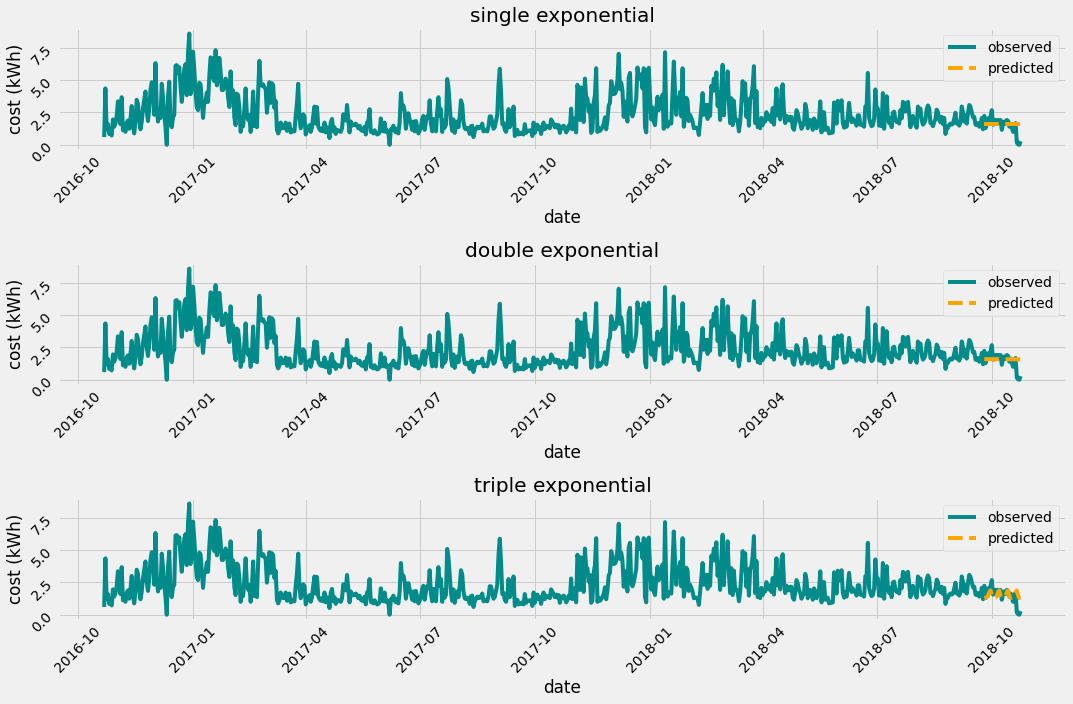

In [617]:
fig,axes = plt.subplots(3,1, figsize = (15,10))

axes[0].plot(ts_data.index, ts_data['Cost'], color='darkcyan', label='observed')
axes[0].plot(smoothed_data_preds_1.index, smoothed_data_preds_1, color='orange', linestyle='--', label='predicted')
axes[0].set_title('single exponential')
axes[0].set_xlabel('date')
axes[0].set_ylabel('cost (kWh)')
axes[0].tick_params(labelrotation=45)
axes[0].legend()

axes[1].plot(ts_data.index, ts_data['Cost'], color='darkcyan', label='observed')
axes[1].plot(smoothed_data_preds_2.index, smoothed_data_preds_2, color='orange', linestyle='--', label='predicted')
axes[1].set_title('double exponential')
axes[1].set_xlabel('date')
axes[1].set_ylabel('cost (kWh)')
axes[1].tick_params(labelrotation=45)
axes[1].legend()

axes[2].plot(ts_data.index, ts_data['Cost'], color='darkcyan', label='observed')
axes[2].plot(smoothed_data_preds_3.index, smoothed_data_preds_3, color='orange', linestyle='--', label='predicted')
axes[2].set_title('triple exponential')
axes[2].set_xlabel('date')
axes[2].set_ylabel('cost (kWh)')
axes[2].tick_params(labelrotation=45)
axes[2].legend()

plt.tight_layout()
plt.show()

In [549]:
def mse(observations, estimates):
    
    difference = observations - estimates
    sq_diff = difference ** 2
    mse = sum(sq_diff)
    
    return mse

In [620]:
mse_1 = round(mse(test['Cost'], smoothed_data_preds_1), 2)
mse_2 = round(mse(test['Cost'], smoothed_data_preds_2), 2)
mse_3 = round(mse(test['Cost'], smoothed_data_preds_3), 2)

print('single exponential mse:', mse_1)
print('double exponential mse:', mse_2)
print('triple exponential mse:', mse_3)

single exponential mse: 12.38
double exponential mse: 12.32
triple exponential mse: 12.35


In [552]:
ar_1 = sm.tsa.ARMA(ts_data, (1,0)).fit(trend='nc', disp=0)
ar_1.params

ar.L1.Cost    0.897347
dtype: float64

In [553]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Cost   No. Observations:                  733
Model:                     ARMA(1, 0)   Log Likelihood               -1180.136
Method:                       css-mle   S.D. of innovations              1.209
Date:                Thu, 22 Apr 2021   AIC                           2364.271
Time:                        16:18:13   BIC                           2373.466
Sample:                    10-22-2016   HQIC                          2367.818
                         - 10-24-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.Cost     0.8973      0.016     55.692      0.000       0.866       0.929
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1144           +0.0000j            1.1144            0.0000
-----------------------------------------------------------------------------
"""

In [554]:
ar_2 = sm.tsa.ARMA(ts_data, (2,0)).fit(trend='nc', disp=0)
ar_2.params

ar.L1.Cost    0.624853
ar.L2.Cost    0.303021
dtype: float64

In [555]:
ar_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Cost   No. Observations:                  733
Model:                     ARMA(2, 0)   Log Likelihood               -1145.242
Method:                       css-mle   S.D. of innovations              1.153
Date:                Thu, 22 Apr 2021   AIC                           2296.484
Time:                        16:18:17   BIC                           2310.275
Sample:                    10-22-2016   HQIC                          2301.804
                         - 10-24-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.Cost     0.6249      0.035     17.679      0.000       0.556       0.694
ar.L2.Cost     0.3030      0.035      8.560      0.000       0.234       0.372
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0578           +0.0000j            1.0578            0.0000
AR.2           -3.1199           +0.0000j            3.1199            0.5000
-----------------------------------------------------------------------------
"""

In [556]:
ar_3 = sm.tsa.ARMA(ts_data, (3,0)).fit(trend='nc', disp=0)
ar_3.params

ar.L1.Cost    0.556058
ar.L2.Cost    0.154762
ar.L3.Cost    0.233178
dtype: float64

In [557]:
ar_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Cost   No. Observations:                  733
Model:                     ARMA(3, 0)   Log Likelihood               -1125.020
Method:                       css-mle   S.D. of innovations              1.121
Date:                Thu, 22 Apr 2021   AIC                           2258.041
Time:                        16:18:20   BIC                           2276.429
Sample:                    10-22-2016   HQIC                          2265.134
                         - 10-24-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.Cost     0.5561      0.036     15.445      0.000       0.485       0.627
ar.L2.Cost     0.1548      0.041      3.737      0.000       0.074       0.236
ar.L3.Cost     0.2332      0.036      6.450      0.000       0.162       0.304
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0351           -0.0000j            1.0351           -0.0000
AR.2           -0.8494           -1.8498j            2.0355           -0.3185
AR.3           -0.8494           +1.8498j            2.0355            0.3185
-----------------------------------------------------------------------------
"""

In [558]:
ar_1_preds = ar_1.predict(start=test.index[0], end=test.index[-1])
ar_2_preds = ar_2.predict(start=test.index[0], end=test.index[-1])
ar_3_preds = ar_3.predict(start=test.index[0], end=test.index[-1])

In [559]:
ar_1_preds

2018-09-25    1.076816
2018-09-26    2.010056
2018-09-27    1.148604
2018-09-28    1.615224
2018-09-29    1.830587
2018-09-30    1.651118
2018-10-01    1.974163
2018-10-02    2.404889
2018-10-03    1.399861
2018-10-04    1.435755
2018-10-05    1.722906
2018-10-06    1.687012
2018-10-07    1.722906
2018-10-08    1.507542
2018-10-09    1.722906
2018-10-10    1.040922
2018-10-11    1.471649
2018-10-12    1.615224
2018-10-13    1.435755
2018-10-14    1.722906
2018-10-15    1.651118
2018-10-16    1.256285
2018-10-17    1.471649
2018-10-18    1.184498
2018-10-19    0.897347
2018-10-20    1.435755
2018-10-21    1.507542
2018-10-22    0.143575
2018-10-23    0.035894
2018-10-24    0.000000
Freq: D, dtype: float64

In [560]:
mse_ar_1 = round(mse(test['Cost'], ar_1_preds), 2)
mse_ar_2 = round(mse(test['Cost'], ar_2_preds), 2)
mse_ar_3 = round(mse(test['Cost'], ar_3_preds), 2)

print('AR 1 mse:', mse_ar_1)
print('AR 2 mse:', mse_ar_2)
print('AR 3 mse:', mse_ar_3)

AR 1 mse: 8.29
AR 2 mse: 6.9
AR 3 mse: 6.52


In [561]:
arma_1 = sm.tsa.ARMA(ts_data, (1,1)).fit(trend='nc', disp=0)
arma_1.params

ar.L1.Cost    0.989618
ma.L1.Cost   -0.672412
dtype: float64

In [562]:
arma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Cost   No. Observations:                  733
Model:                     ARMA(1, 1)   Log Likelihood               -1106.584
Method:                       css-mle   S.D. of innovations              1.093
Date:                Thu, 22 Apr 2021   AIC                           2219.168
Time:                        16:19:40   BIC                           2232.959
Sample:                    10-22-2016   HQIC                          2224.487
                         - 10-24-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1.Cost     0.9896      0.005    186.622      0.000       0.979       1.000
ma.L1.Cost    -0.6724      0.039    -17.158      0.000      -0.749      -0.596
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0105           +0.0000j            1.0105            0.0000
MA.1            1.4872           +0.0000j            1.4872            0.0000
-----------------------------------------------------------------------------
"""

In [563]:
arma_1_preds = arma_1.predict(start=test.index[0], end=test.index[-1])
arma_1_preds

2018-09-25    1.527661
2018-09-26    1.737760
2018-09-27    1.574515
2018-09-28    1.629694
2018-09-29    1.742927
2018-09-30    1.755625
2018-10-01    1.878357
2018-10-02    2.113143
2018-10-03    1.915744
2018-10-04    1.795700
2018-10-05    1.816486
2018-10-06    1.817775
2018-10-07    1.831330
2018-10-08    1.764315
2018-10-09    1.795383
2018-10-10    1.575196
2018-10-11    1.579399
2018-10-12    1.632978
2018-10-13    1.605564
2018-10-14    1.688637
2018-10-15    1.719119
2018-10-16    1.600045
2018-10-17    1.596108
2018-10-18    1.491955
2018-10-19    1.320414
2018-10-20    1.395393
2018-10-21    1.471185
2018-10-22    1.039996
2018-10-23    0.711994
2018-10-24    0.478753
Freq: D, dtype: float64

In [564]:
mse_arma_1 = round(mse(test['Cost'], arma_1_preds), 2)
mse_arma_1

6.69

In [565]:
ma_1 = sm.tsa.ARMA(ts_data, (0,1)).fit(trend='nc', disp=0)
ma_1.params

ma.L1.Cost    0.711463
dtype: float64

In [566]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Cost   No. Observations:                  733
Model:                     ARMA(0, 1)   Log Likelihood               -1507.037
Method:                       css-mle   S.D. of innovations              1.890
Date:                Thu, 22 Apr 2021   AIC                           3018.074
Time:                        16:20:11   BIC                           3027.268
Sample:                    10-22-2016   HQIC                          3021.620
                         - 10-24-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.Cost     0.7115      0.020     35.253      0.000       0.672       0.751
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.4056           +0.0000j            1.4056            0.5000
-----------------------------------------------------------------------------
"""

In [567]:
ma_1_preds = ma_1.predict(start=test.index[0], end=test.index[-1])
ma_1_preds

2018-09-25    0.129697
2018-09-26    1.501402
2018-09-27   -0.157519
2018-09-28    1.392701
2018-09-29    0.460529
2018-09-30    0.981442
2018-10-01    0.866958
2018-10-02    1.289911
2018-10-03    0.192158
2018-10-04    1.001627
2018-10-05    0.653388
2018-10-06    0.872688
2018-10-07    0.745123
2018-10-08    0.665130
2018-10-09    0.892793
2018-10-10    0.190108
2018-10-11    1.031544
2018-10-12    0.546728
2018-10-13    0.749364
2018-10-14    0.832864
2018-10-15    0.716540
2018-10-16    0.486256
2018-10-17    0.820845
2018-10-18    0.355130
2018-10-19    0.458801
2018-10-20    0.811920
2018-10-21    0.617606
2018-10-22   -0.325570
2018-10-23    0.260089
2018-10-24   -0.185044
Freq: D, dtype: float64

In [568]:
mse_ma_1 = round(mse(test['Cost'], ma_1_preds), 2)
mse_ma_1

34.78

In [569]:
ma_2 = sm.tsa.ARMA(ts_data, (0,2)).fit(trend='nc', disp=0)
ma_2.params

ma.L1.Cost    0.811116
ma.L2.Cost    0.481088
dtype: float64

In [570]:
ma_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                   Cost   No. Observations:                  733
Model:                     ARMA(0, 2)   Log Likelihood               -1396.067
Method:                       css-mle   S.D. of innovations              1.624
Date:                Thu, 22 Apr 2021   AIC                           2798.134
Time:                        16:20:37   BIC                           2811.925
Sample:                    10-22-2016   HQIC                          2803.453
                         - 10-24-2018                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1.Cost     0.8111      0.037     21.831      0.000       0.738       0.884
ma.L2.Cost     0.4811      0.029     16.390      0.000       0.424       0.539
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -0.8430           -1.1696j            1.4417           -0.3494
MA.2           -0.8430           +1.1696j            1.4417            0.3494
-----------------------------------------------------------------------------
"""

In [571]:
ma_2_preds = ma_2.predict(start=test.index[0], end=test.index[-1])
ma_2_preds

2018-09-25    0.446457
2018-09-26    1.345647
2018-09-27    0.809605
2018-09-28    0.771743
2018-09-29    1.505170
2018-09-30    0.881729
2018-10-01    1.230353
2018-10-02    1.810036
2018-10-03    0.494600
2018-10-04    0.776318
2018-10-05    1.459453
2018-10-06    0.891324
2018-10-07    1.036695
2018-10-08    1.016678
2018-10-09    1.042185
2018-10-10    0.530139
2018-10-11    0.956905
2018-10-12    1.217788
2018-10-13    0.715621
2018-10-14    1.160768
2018-10-15    1.130348
2018-10-16    0.545489
2018-10-17    1.017501
2018-10-18    0.771918
2018-10-19    0.330530
2018-10-20    1.139415
2018-10-21    1.049204
2018-10-22   -0.461178
2018-10-23   -0.021272
2018-10-24    0.258365
Freq: D, dtype: float64

In [572]:
mse_ma_2 = round(mse(test['Cost'], ma_2_preds), 2)
mse_ma_2

23.19

In [573]:
import pmdarima as pm

In [574]:
stepwise_model = pm.auto_arima(ts_data['Cost'], start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=1.50 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=2818.684, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=2439.336, Time=0.44 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=2358.770, Time=0.68 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=2816.714, Time=0.05 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=2686.787, Time=0.20 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=inf, Time=2.67 sec
 ARIMA(0,0,1)(0,1,2)[12] intercept   : AIC=2359.191, Time=2.18 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=2478.222, Time=0.39 sec
 ARIMA(0,0,1)(1,1,2)[12] intercept   : AIC=inf, Time=7.35 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=2532.140, Time=0.48 sec
 ARIMA(0,0,2)(0,1,1)[12] intercept   : AIC=2314.175, Time=0.95 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=2668.124, Time=0.28 sec
 ARIMA(0,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(0,0,2)(0,1,2)[12] intercept   : 

In [580]:
sar = sm.tsa.statespace.SARIMAX(ts_data['Cost'], order=(0,0,2), seasonal_order=(0, 1, 1, 12), trend='c').fit()

In [581]:
sar_preds = sar.predict(start=test.index[0], end=test.index[-1])
sar_preds

2018-09-25    1.717442
2018-09-26    2.161898
2018-09-27    1.849346
2018-09-28    2.096930
2018-09-29    1.915282
2018-09-30    1.691707
2018-10-01    2.216182
2018-10-02    2.423118
2018-10-03    1.586873
2018-10-04    1.813964
2018-10-05    1.946697
2018-10-06    2.035578
2018-10-07    2.047888
2018-10-08    1.849213
2018-10-09    2.022739
2018-10-10    1.887984
2018-10-11    1.592139
2018-10-12    1.820370
2018-10-13    2.008965
2018-10-14    1.897085
2018-10-15    1.780678
2018-10-16    1.793939
2018-10-17    1.706776
2018-10-18    1.786075
2018-10-19    1.576178
2018-10-20    1.836218
2018-10-21    1.875551
2018-10-22    1.326536
2018-10-23    0.854962
2018-10-24    1.018316
Freq: D, Name: predicted_mean, dtype: float64

In [582]:
mse_sarima = round(mse(test['Cost'], sar_preds), 2)
mse_sarima

10.19

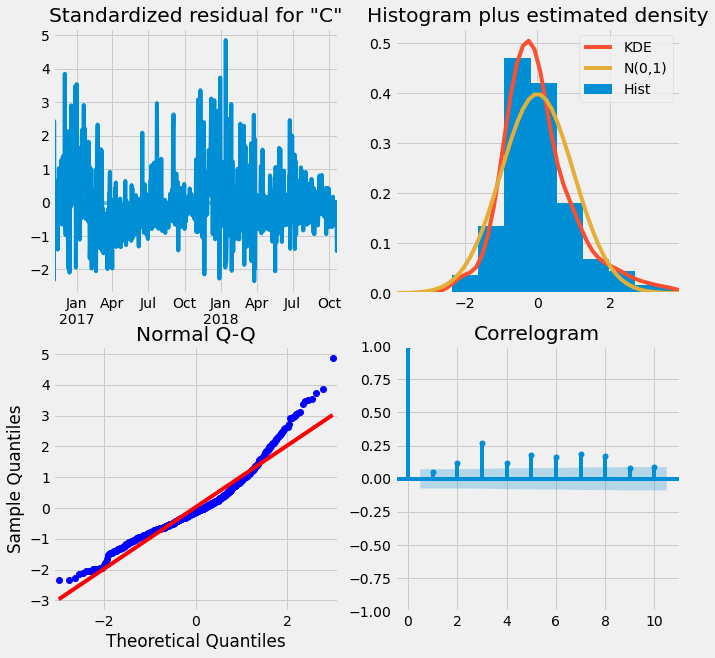

In [583]:
sar.plot_diagnostics(figsize=(10,10));

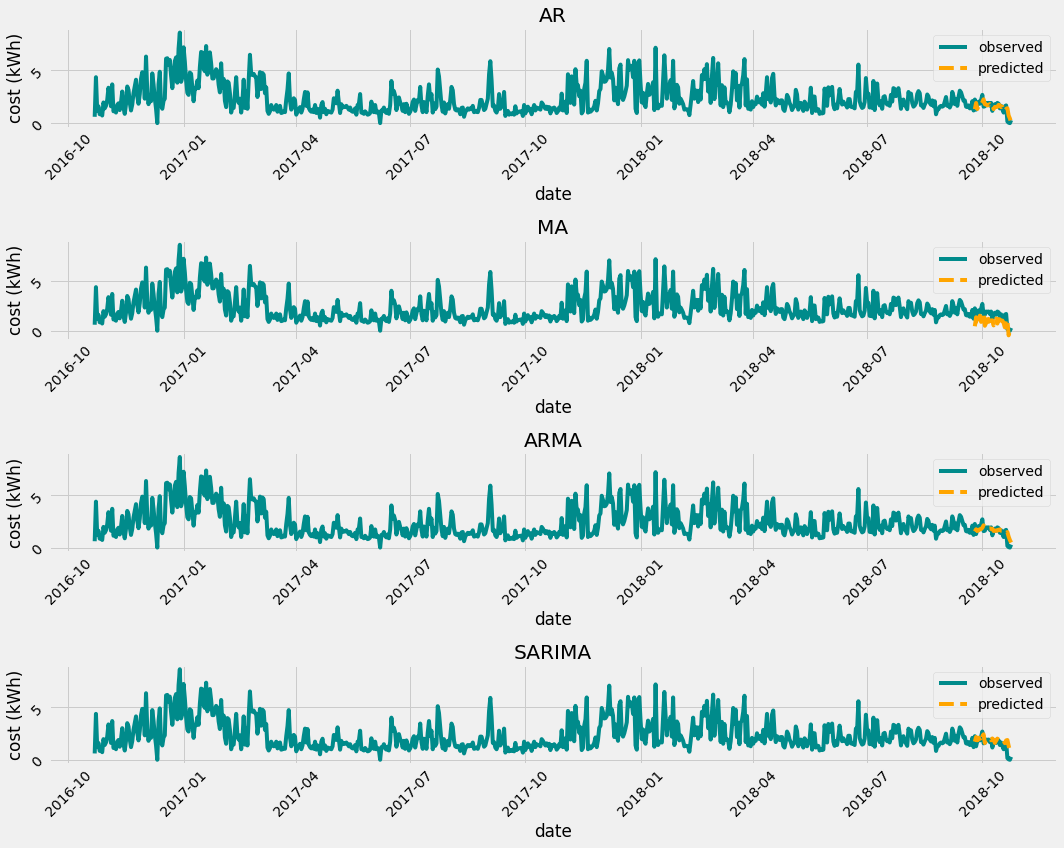

In [618]:
fig,axes = plt.subplots(4,1, figsize = (15,12))

axes[0].plot(ts_data.index, ts_data['Cost'], color='darkcyan', label='observed')
axes[0].plot(test.index, ar_3_preds, color='orange', linestyle='--', label='predicted')
axes[0].set_title('AR')
axes[0].set_xlabel('date')
axes[0].set_ylabel('cost (kWh)')
axes[0].tick_params(labelrotation=45)
axes[0].legend()

axes[1].plot(ts_data.index, ts_data['Cost'], color='darkcyan', label='observed')
axes[1].plot(test.index, ma_2_preds, color='orange', linestyle='--', label='predicted')
axes[1].set_title('MA')
axes[1].set_xlabel('date')
axes[1].set_ylabel('cost (kWh)')
axes[1].tick_params(labelrotation=45)
axes[1].legend()

axes[2].plot(ts_data.index, ts_data['Cost'], color='darkcyan', label='observed')
axes[2].plot(test.index, arma_1_preds, color='orange', linestyle='--', label='predicted')
axes[2].set_title('ARMA')
axes[2].set_xlabel('date')
axes[2].set_ylabel('cost (kWh)')
axes[2].tick_params(labelrotation=45)
axes[2].legend()

axes[3].plot(ts_data.index, ts_data['Cost'], color='darkcyan', label='observed')
axes[3].plot(test.index, sar_preds, color='orange', linestyle='--', label='predicted')
axes[3].set_title('SARIMA')
axes[3].set_xlabel('date')
axes[3].set_ylabel('cost (kWh)')
axes[3].tick_params(labelrotation=45)
axes[3].legend()

plt.tight_layout()
plt.show()

In [592]:
print('AR mse:', mse_ar_3)
print('MA mse:', mse_ma_2)
print('ARMA mse:', mse_arma_1)
print('SARIMA mse:', mse_sarima)

AR mse: 6.52
MA mse: 23.19
ARMA mse: 6.69
SARIMA mse: 10.19
